In [15]:
! nvidia-smi

Tue Jun 22 06:13:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    32W /  70W |   2960MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
! pip install keras-tuner

In [17]:
import tensorflow
from tensorflow import keras
import keras_tuner as kt
import os
import numpy as np
# import keras
import keras.backend as K
from tensorflow.keras.layers import Input, Masking, LSTM, Dropout, Permute, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, concatenate, multiply, Reshape, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from matplotlib import pyplot as plt

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
num_classes = 745

### Some utility functions

In [20]:
def load_X(path):
    X_signals = []
    files = os.listdir(path)
    files.sort(key=str.lower)
    #['train_acc_x.txt', 'train_acc_y.txt', 'train_acc_z.txt', 'train_gyr_x.txt', 'train_gyr_y.txt', 'train_gyr_z.txt']
    for my_file in files:
        fileName = os.path.join(path,my_file)
        file = open(fileName, 'r')
        X_signals.append(
            [np.array(cell, dtype=np.float32) for cell in [
                row.strip().split(' ') for row in file
            ]]
        )
        file.close()
        #X_signals = 6*totalStepNum*128
    X_signals = np.transpose(np.array(X_signals), (1, 0, 2))#(totalStepNum*6*128)
    return X_signals.reshape(-1,6,128,1)#(totalStepNum*6*128*1)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    y_ = y_ - 1
    #one_hot
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

In [21]:
def plot_performance(X_train, train_label):
    history = model.fit(X_train, train_label, validation_split = 0.1, epochs=100, shuffle=True, batch_size=512, callbacks=keras.callbacks.EarlyStopping(monitor='val_loss', patience=50))#, callbacks=[es_callback])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [22]:
def get_test_performance(model, X_test, test_label):
    score = model.evaluate(X_test, test_label, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

### Squeeze Excite Block

In [23]:
def squeeze_excite_block(tensor, ratio=16):
    init = tensor
    # channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init.shape[-1]
    se_shape = (1, filters)

    se = GlobalAveragePooling1D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    # if K.image_data_format() == 'channels_first':
    #     se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x

# OU-ISIR

# Model without Tuning

In [ ]:
def MLSTM_FCN(shape=shape, num_classes):
    x = Input(shape=(6, 128))
    ip = x
    x = Masking()(ip)
    x = LSTM(units=8)(x)
    x = Dropout(0.8)(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")
    model.summary()

    return model

In [ ]:
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/data')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/data')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/train_y.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/test_y.txt')
print(f'{X_train.shape} {X_test.shape}')

(13212, 6, 128, 1) (1409, 6, 128, 1)


In [ ]:
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 6, 128)]     0                                            
__________________________________________________________________________________________________
permute_4 (Permute)             (None, 128, 6)       0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 128, 128)     6272        permute_4[0][0]                  
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 128, 128)     512         conv1d_12[0][0]                  
____________________________________________________________________________________________

Epoch 1/100
24/24 [==============================] - 7s 128ms/step - loss: 6.5068 - accuracy: 0.0096 - val_loss: 6.5929 - val_accuracy: 7.5643e-04
Epoch 2/100
24/24 [==============================] - 2s 71ms/step - loss: 6.0734 - accuracy: 0.0324 - val_loss: 6.5303 - val_accuracy: 0.0083
Epoch 3/100
24/24 [==============================] - 2s 72ms/step - loss: 5.5168 - accuracy: 0.0470 - val_loss: 6.3923 - val_accuracy: 0.0083
Epoch 4/100
24/24 [==============================] - 2s 71ms/step - loss: 4.9879 - accuracy: 0.0848 - val_loss: 6.2053 - val_accuracy: 0.0038
Epoch 5/100
24/24 [==============================] - 2s 72ms/step - loss: 4.5188 - accuracy: 0.1426 - val_loss: 6.2131 - val_accuracy: 0.0038
Epoch 6/100
24/24 [==============================] - 2s 71ms/step - loss: 4.0836 - accuracy: 0.2278 - val_loss: 6.2031 - val_accuracy: 0.0045
Epoch 7/100
24/24 [==============================] - 2s 72ms/step - loss: 3.6638 - accuracy: 0.3263 - val_loss: 6.3362 - val_accuracy: 0.0083
E

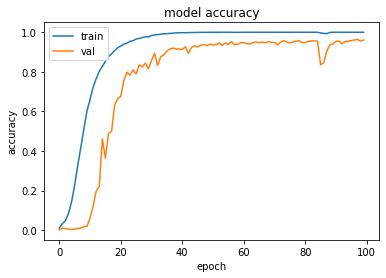

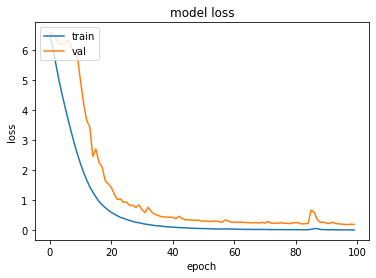

In [ ]:
plot_performance(X_train, train_label)

In [ ]:
get_test_performance(model, X_test, test_label)

Test loss: 0.29558420181274414
Test accuracy: 0.9439318776130676


In [ ]:
model.save('/content/drive/Shareddrives/MMH/models/MLSTM_FCN_OU-ISIR_94_39.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Model Tuned with keras Tuner

In [25]:
def MLSTM_FCN_tuned_all(hp):
    ip = Input(shape=(6, 128))
    x = Masking()(ip)
    x = LSTM(units=hp.Int('lstm_1', min_value=8, max_value=128, step=16))(x)
    x = Dropout(hp.Choice(name='Dropout', values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(hp.Int('conv_1_filter', min_value=8, max_value=128, step=16), hp.Choice(name='conv_1_filter_stride', values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Int('conv_2_filter', min_value=8, max_value=128, step=16), hp.Choice(name='conv_2_filter_stride',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Int('conv_3_filter', min_value=8, max_value=128, step=16), hp.Choice(name='conv_3_filter_stride',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 3*1e-1, 3*1e-2, 3*1e-3, 3*1e-4, 1e-4, 1.0])), \
                  loss='categorical_crossentropy',metrics=['accuracy'])
    # model.summary()

    return model

In [26]:
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/data')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/data')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/train_y.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/test_y.txt')

In [27]:
tuner = kt.tuners.RandomSearch(
    MLSTM_FCN_tuned_all,
    objective='val_accuracy',
    max_trials=10,
    directory='output',
    project_name='MLSTM_FCN_OS')

tuner.search(X_train, train_label, epochs=100, validation_split=0.1, callbacks=[tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)], shuffle=True)

Trial 10 Complete [00h 07m 15s]
val_accuracy: 0.8827534317970276

Best val_accuracy So Far: 0.9818456768989563
Total elapsed time: 01h 08m 32s
INFO:tensorflow:Oracle triggered exit


In [28]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 128)]     0                                            
__________________________________________________________________________________________________
permute (Permute)               (None, 128, 6)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 128, 88)      4840        permute[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 88)      352         conv1d[0][0]                     
______________________________________________________________________________________________

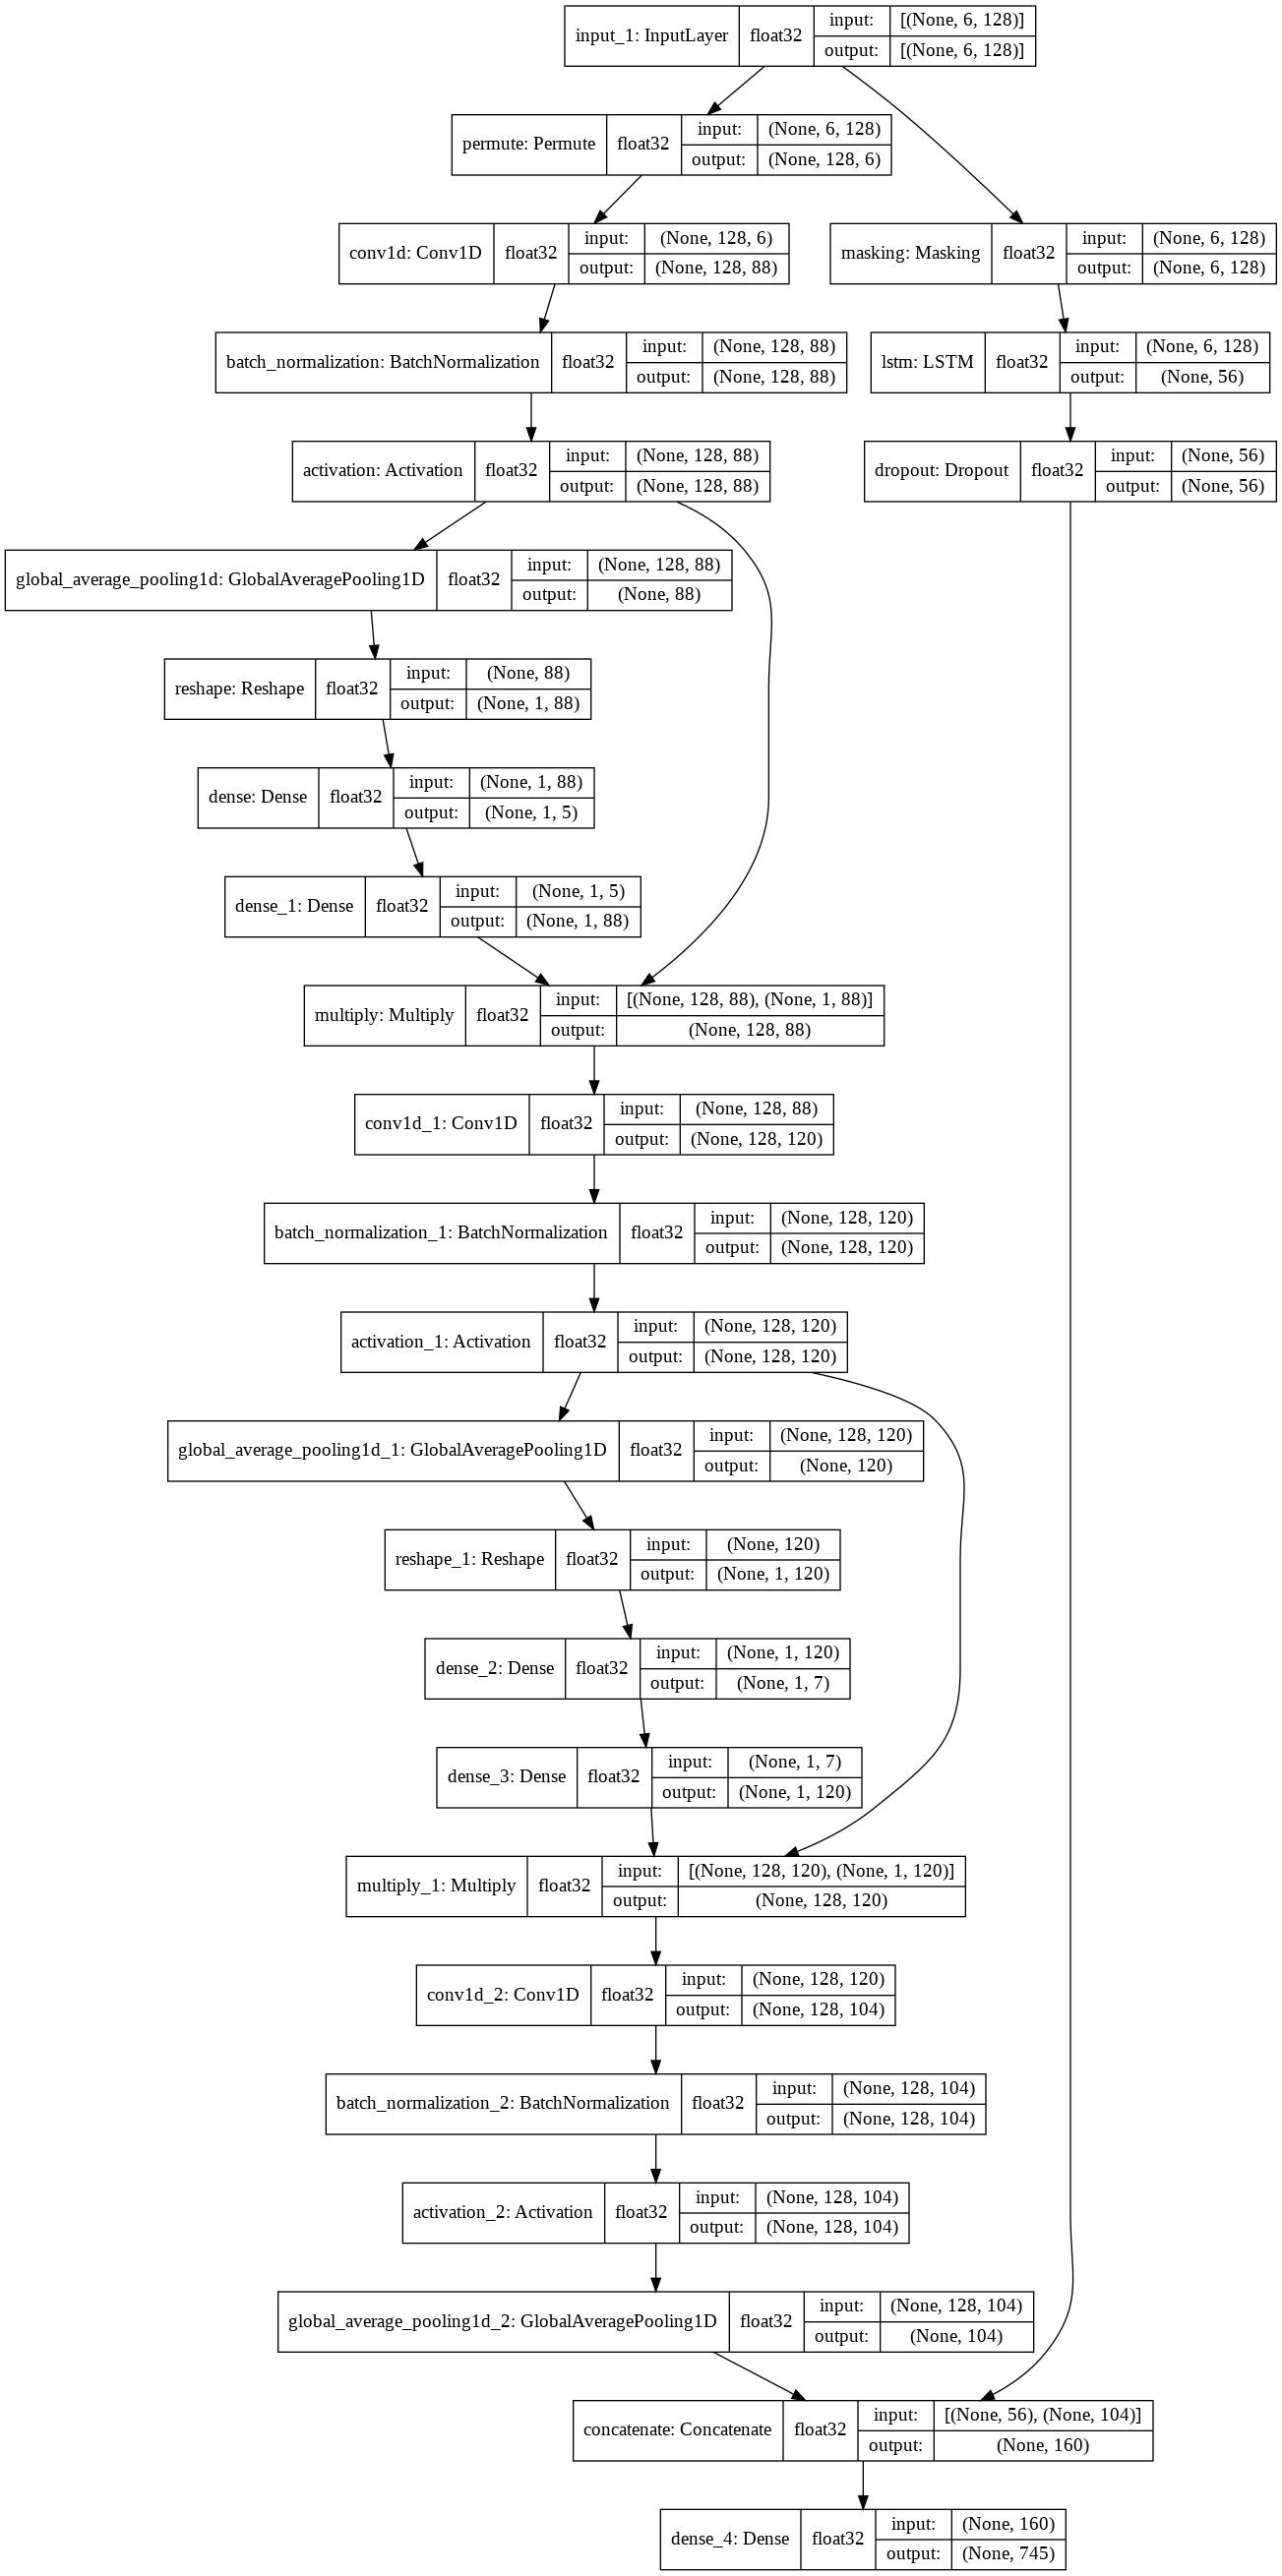

In [29]:
tensorflow.keras.utils.plot_model(
    model, to_file='/content/drive/Shareddrives/MMH/models/images/MLSTM_FCN_tuned_OS.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
)

Epoch 1/100
24/24 [==============================] - 7s 115ms/step - loss: 3.8703e-04 - accuracy: 1.0000 - val_loss: 0.0850 - val_accuracy: 0.9841
Epoch 2/100
24/24 [==============================] - 1s 50ms/step - loss: 2.6306e-04 - accuracy: 1.0000 - val_loss: 0.0827 - val_accuracy: 0.9841
Epoch 3/100
24/24 [==============================] - 1s 49ms/step - loss: 1.9717e-04 - accuracy: 1.0000 - val_loss: 0.0815 - val_accuracy: 0.9849
Epoch 4/100
24/24 [==============================] - 1s 50ms/step - loss: 2.4464e-04 - accuracy: 1.0000 - val_loss: 0.0806 - val_accuracy: 0.9856
Epoch 5/100
24/24 [==============================] - 1s 50ms/step - loss: 1.9443e-04 - accuracy: 1.0000 - val_loss: 0.0799 - val_accuracy: 0.9856
Epoch 6/100
24/24 [==============================] - 1s 50ms/step - loss: 2.4659e-04 - accuracy: 1.0000 - val_loss: 0.0791 - val_accuracy: 0.9856
Epoch 7/100
24/24 [==============================] - 1s 49ms/step - loss: 1.1328e-04 - accuracy: 1.0000 - val_loss: 0.0787 

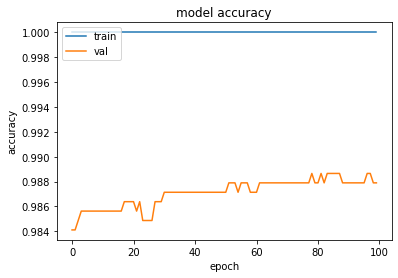

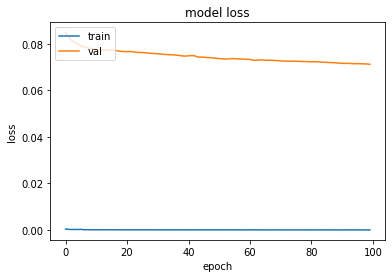

In [30]:
plot_performance(X_train, train_label)

In [31]:
get_test_performance(model, X_test, test_label)

Test loss: 0.16494834423065186
Test accuracy: 0.9645138382911682


In [32]:
model.save('/content/drive/Shareddrives/MMH/models/MLSTM_FCN_tuned_OS.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
def MLSTM_FCN_tuned_all(hp):
    ip = Input(shape=(6, 128))
    x = Masking()(ip)
    x = LSTM(units=hp.Int('lstm_1', min_value=8, max_value=128, step=16))(x)
    x = Dropout(hp.Choice(name='Dropout', values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(hp.Int('conv_1_filter', min_value=8, max_value=128, step=16), hp.Choice(name='conv_1_filter_stride', values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Int('conv_2_filter', min_value=8, max_value=128, step=16), hp.Choice(name='conv_2_filter_stride',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Int('conv_3_filter', min_value=8, max_value=128, step=16), hp.Choice(name='conv_3_filter_stride',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 3*1e-1, 3*1e-2, 3*1e-3, 3*1e-4, 1e-4, 1.0])), \
                  loss='categorical_crossentropy',metrics=['accuracy'])
    # model.summary()

    return model

In [37]:
layers = ['lstm_1', 'Dropout', 'conv_1_filter', 'conv_1_filter_stride', 'conv_2_filter', 'conv_2_filter_stride', 'conv_3_filter', 'conv_3_filter_stride', 'learning_rate']

In [38]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print('Optimal Hyperparameters:')

for i in layers:
    print(f"{i}: {best_hyperparameters.get(i)}")

Optimal Hyperparameters:
lstm_1: 56
Dropout: 0.5
conv_1_filter: 88
conv_1_filter_stride: 9
conv_2_filter: 120
conv_2_filter_stride: 7
conv_3_filter: 104
conv_3_filter_stride: 7
learning_rate: 0.003


> Accuracy achived: 
 - Without Tuner: 94.39 (Previous best: 66.36) 
 - With Tuner: 96.45 (Previous best: 72.32)